<a href="https://colab.research.google.com/github/EribertoO/NYS-Turnstile-Usage-Data/blob/main/nyc_subway_turnstile_traffic_eriberto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# Import the libraries we need
# Set up
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from datetime import datetime, date, timedelta

# import packages
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import os

# Any results you write to the current directory are saved as output.

In [2]:
# My personal link to the dados test.
#https://drive.google.com/file/d/1u-yOsb2leD4ToOwdqCXGQwplU4fSD18w/view?usp=sharing
!gdown --id 1u-yOsb2leD4ToOwdqCXGQwplU4fSD18w

Downloading...
From: https://drive.google.com/uc?id=1u-yOsb2leD4ToOwdqCXGQwplU4fSD18w
To: /content/C_pia de dados_desafio.zip
1.21GB [00:08, 152MB/s]


In [7]:
!unzip /content/dados_desafio.zip

Archive:  /content/dados_desafio.zip
 extracting: 2010.csv.gz             
 extracting: 2011.csv.gz             
 extracting: 2012.csv.gz             
 extracting: 2013.csv.gz             
 extracting: 2014.csv.gz             
 extracting: 2015.csv.gz             
 extracting: 2016.csv.gz             
replace 2017.csv.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: 2017.csv.gz             


In [9]:
import os
import gzip
import shutil
search_path = os.getcwd()
file_type = ".gz"
for fname in os.listdir(path=search_path):
    if fname.endswith(file_type):
        with gzip.open(fname,'rb') as f_in:
            with open(fname+'.csv','wb') as f_out:
                shutil.copyfileobj(f_in,f_out)

OSError: ignored

In [15]:
# filename: data set to load from kernel
data_path = "2011.csv.gz.csv"

data = pd.read_csv(data_path, parse_dates=['time'])

In [16]:
def fix_col_names(df):
    #Fix columns with trailing spaces
    df.columns = df.columns.str.strip()
    #Fix Columns with spaces in column name.
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]

In [17]:
fix_col_names(data)

In [18]:
data.head()

,time,ca,unit,scp,station,linename,division,desc,entries,exits
0,2011-01-01,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2994127.0,1033610.0
1,2011-01-01,A002,R051,02-00-01,LEXINGTON AVE,456NQR,BMT,REGULAR,2959715.0,627670.0
2,2011-01-01,A002,R051,02-03-00,LEXINGTON AVE,456NQR,BMT,REGULAR,1235350.0,4380835.0
3,2011-01-01,A002,R051,02-03-01,LEXINGTON AVE,456NQR,BMT,REGULAR,2709282.0,4179651.0
4,2011-01-01,A002,R051,02-03-02,LEXINGTON AVE,456NQR,BMT,REGULAR,2488392.0,3405802.0


In [19]:
#narrow columns to only the ones that we're interested in.
data = data.filter(['station', 'time', 'entries', 'exits'], axis=1)
# data = data.set_index(['station','date'])
data.tail(n=20)

,station,time,entries,exits
11146395,PATH WTC,2011-12-31 23:51:00,1497409.0,2028170.0
11146396,NaN,2011-12-31 23:51:35,2138490.0,340185.0
11146397,NaN,2011-12-31 23:51:44,2138490.0,340185.0
11146398,NEWARK HW BMEBE,2011-12-31 23:52:35,658724.0,14018.0
11146399,PATH WTC,2011-12-31 23:52:43,447466.0,618318.0
11146400,JFK JAMAICA CT1,2011-12-31 23:52:49,11826.0,10165.0
11146401,TWENTY THIRD ST,2011-12-31 23:53:20,485380.0,4465.0
11146402,34 ST-PENN STA,2011-12-31 23:54:53,3096657.0,2294174.0
11146403,CITY / BUS,2011-12-31 23:54:54,408790.0,108354.0
11146404,HARRISON,2011-12-31 23:56:18,296631.0,27986.0


In [20]:
df = data
df.head()

,station,time,entries,exits
0,LEXINGTON AVE,2011-01-01,2994127.0,1033610.0
1,LEXINGTON AVE,2011-01-01,2959715.0,627670.0
2,LEXINGTON AVE,2011-01-01,1235350.0,4380835.0
3,LEXINGTON AVE,2011-01-01,2709282.0,4179651.0
4,LEXINGTON AVE,2011-01-01,2488392.0,3405802.0


In [21]:
len(df.station.unique())

383

In [23]:
station_day_sum = (df.groupby(by='station')
                   .apply(lambda x: x.resample(rule='1D', on='time')
                   .agg({'entries': 'sum', 'exits': 'sum'}))
                  )

station_day_sum.head()

entries        exits
station time                                
1 AVE   2011-01-01  232541330.0  199821272.0
        2011-01-02  232624692.0  199914816.0
        2011-01-03  232704316.0  200009509.0
        2011-01-04  232830124.0  200151208.0
        2011-01-05  256354593.0  214767796.0

In [24]:
# Evluetse the correlation
# Global variables. i.e all stations included 
station_day_sum.corr()

,entries,exits
entries,1.000000,0.952591
exits,0.952591,1.000000


In [ ]:
# Since the correlation was high, more uncorrelated variables should be used , 

In [25]:
# Uma vez que a correlação é alta entre entra e saída 
# um modelo deve conter variaves de entrada q são não colineares 
# portanto foram criadas novas varipaveis
# Function to calculate several metrics on the dataset
# Now that it's grouped by station, date
def calculate_flow_stats(row):
    d = row.entries - row.exits
    return(row.entries + row.exits, d, abs(d))

## row function returns tuple of values that need to be spread out to each new column
def apply_flow_stats(df):
    (df['flowtotal'], df['flowdelta'],df['flowabs']) = zip(*df.apply(calculate_flow_stats, axis=1))

apply_flow_stats(station_day_sum)
station_day_sum.head()

entries        exits  ...   flowdelta     flowabs
station time                                  ...                        
1 AVE   2011-01-01  232541330.0  199821272.0  ...  32720058.0  32720058.0
        2011-01-02  232624692.0  199914816.0  ...  32709876.0  32709876.0
        2011-01-03  232704316.0  200009509.0  ...  32694807.0  32694807.0
        2011-01-04  232830124.0  200151208.0  ...  32678916.0  32678916.0
        2011-01-05  256354593.0  214767796.0  ...  41586797.0  41586797.0

[5 rows x 5 columns]

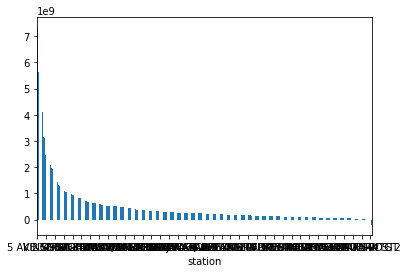

In [32]:
stationList = station_day_sum.groupby('station')['flowtotal'].mean().sort_values(ascending=False)
n = 10
ax = stationList.plot.bar( rot=0)
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::n])
ax.xaxis.set_ticklabels(ticklabels[::n])

ax.figure.show()


In [33]:
# correlacao entre todas as estacoes 

corr = station_day_sum.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(4)

# Descomente para obter a formato dos dados
#station_day_sum.groupby
#station_day_sum.index
#station_day_sum

,entries,exits,flowtotal,flowdelta,flowabs
entries,1.0000,0.9526,0.9879,0.1128,0.5712
exits,0.9526,1.0000,0.9882,-0.1949,0.5290
flowtotal,0.9879,0.9882,1.0000,-0.0425,0.5566
flowdelta,0.1128,-0.1949,-0.0425,1.0000,0.1137
flowabs,0.5712,0.5290,0.5566,0.1137,1.0000


In [34]:
# Para verificar os dados globais um vez que a correlação é muito alta
station_day_sum.unstack(level=0)

entries               ...    flowabs            
station           1 AVE       103 ST  ...    YORK ST  ZEREGA AVE
time                                  ...                       
2011-01-01  232541330.0  557738613.0  ...  5695710.0  27613442.0
2011-01-02  232624692.0  543010534.0  ...  5697011.0  27614199.0
2011-01-03  232704316.0  575097801.0  ...  5695317.0  27617424.0
2011-01-04  232830124.0  553525253.0  ...  5697425.0  27623311.0
2011-01-05  256354593.0  557971456.0  ...  5700086.0  27226527.0
...                 ...          ...  ...        ...         ...
2011-12-27  274513935.0  630170941.0  ...  9907737.0  29250954.0
2011-12-28  274606567.0  614582643.0  ...  6493850.0  29255370.0
2011-12-29  274714891.0  625150640.0  ...  6496962.0  29260083.0
2011-12-30  274832439.0  677813483.0  ...  6499557.0  29264755.0
2011-12-31  274953094.0  649524584.0  ...  6505211.0  30047962.0

[365 rows x 1910 columns]

In [37]:
# Uma alternativa seria usar todo banco de dados
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer()
data_with_imputed_values = my_imputer.fit_transform(station_day_sum.unstack(level=0))
# Make an instance of the Model
pca = PCA(.95)
pca.fit(data_with_imputed_values)
train_img = pca.transform(data_with_imputed_values)
train_img.shape
print(data_with_imputed_values.shape)
print(train_img.shape)

(365, 1910)
(365, 8)


In [38]:
# Logo apenas 4 colunas do PCA representam toda a variancia de 1895 colunas
# Esse excesso de correlação é prejudicial a generalização do modelo, devido ao efeito multicolineridade 
#

In [39]:
# Veriicou q os dados globalmente são altamente correlatos corroborando o resultados do PCA
correlations = station_day_sum.unstack(level=0).corr()
print(correlations)

                          entries            ...   flowabs           
station                     1 AVE    103 ST  ...   YORK ST ZEREGA AVE
        station                              ...                     
entries 1 AVE            1.000000 -0.026643  ... -0.075498  -0.118659
        103 ST          -0.026643  1.000000  ...  0.254564   0.405906
        103 ST-CORONA    0.146722 -0.075103  ... -0.041495  -0.154168
        104 ST           0.114349 -0.058343  ... -0.074569  -0.150880
        110 ST          -0.112663 -0.251160  ... -0.137220  -0.201657
...                           ...       ...  ...       ...        ...
flowabs WOODHAVEN BLVD  -0.178561  0.070425  ...  0.046436   0.225404
        WOODLAWN ROAD    0.225348 -0.171883  ... -0.126907  -0.283095
        WORLD TRADE CTR  0.189286 -0.058521  ... -0.075717  -0.138900
        YORK ST         -0.075498  0.254564  ...  1.000000   0.223190
        ZEREGA AVE      -0.118659  0.405906  ...  0.223190   1.000000

[1910 rows x 1910 c

In [41]:
# EDA para os dados locais

# Define para qual estação ira realizar a previsao
# Data sanization
# remove NAN or null
data = station_day_sum.xs('1 AVE')
data.fillna(0)

,entries,exits,flowtotal,flowdelta,flowabs
time,,,,,
2011-01-01,232541330.0,199821272.0,432362602.0,32720058.0,32720058.0
2011-01-02,232624692.0,199914816.0,432539508.0,32709876.0,32709876.0
2011-01-03,232704316.0,200009509.0,432713825.0,32694807.0,32694807.0
2011-01-04,232830124.0,200151208.0,432981332.0,32678916.0,32678916.0
2011-01-05,256354593.0,214767796.0,471122389.0,41586797.0,41586797.0
...,...,...,...,...,...
2011-12-27,274513935.0,246108462.0,520622397.0,28405473.0,28405473.0
2011-12-28,274606567.0,246224684.0,520831251.0,28381883.0,28381883.0
2011-12-29,274714891.0,246352456.0,521067347.0,28362435.0,28362435.0


In [42]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
entries,365.0,2.813631e+08,4.347393e+07,208032290.0,257932296.0,273370992.0,289437998.0,5.893564e+08
exits,365.0,2.496476e+08,4.526574e+07,176498537.0,224182667.0,243235240.0,258437191.0,5.679855e+08
flowtotal,365.0,5.310107e+08,8.799443e+07,384530827.0,482875690.0,516586941.0,550457939.0,1.128986e+09
flowdelta,365.0,3.171549e+07,1.161556e+07,-61124393.0,28986798.0,32423033.0,35025601.0,1.141766e+08
flowabs,365.0,3.272917e+07,8.331589e+06,1957428.0,29517188.0,32440841.0,35058075.0,1.141766e+08


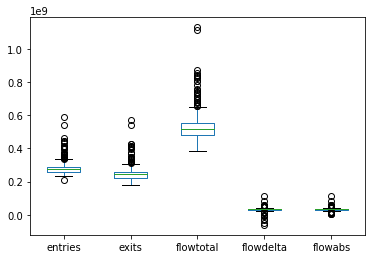

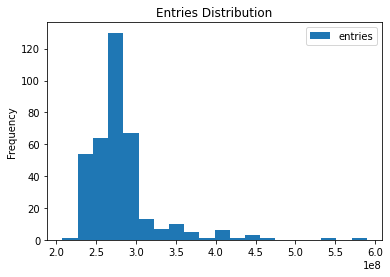

In [43]:
# EDA ANALUSYS within the station data 
data[['entries','exits','flowtotal','flowdelta','flowabs']].plot.box()

data[['entries']].plot.hist(bins = 20, title = 'Entries Distribution')


In [44]:
# print the head of the dataframe
df = data
df.shape

(365, 5)

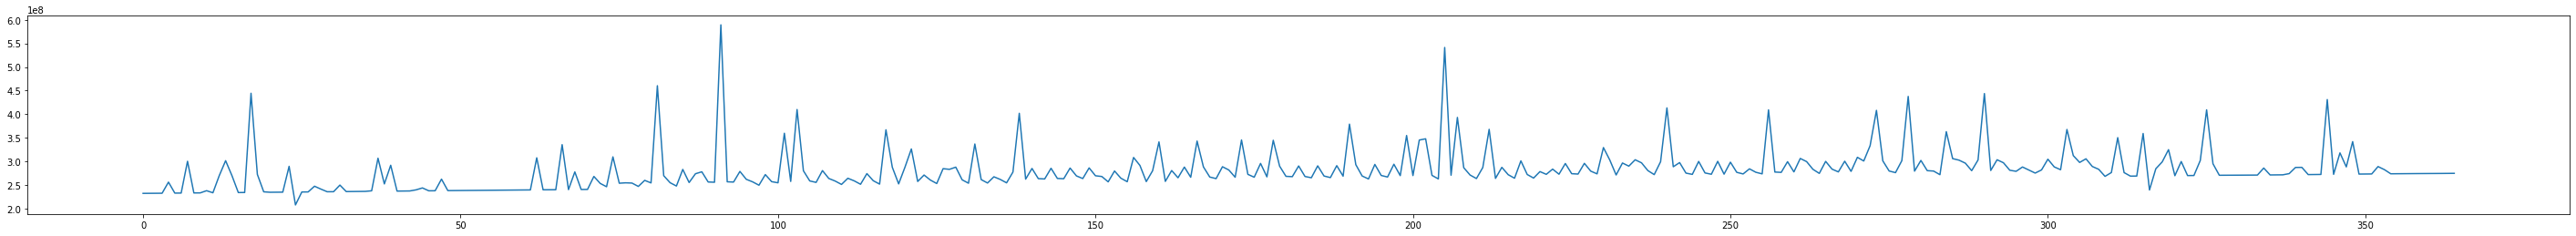

In [45]:
plt.figure(figsize=(50,4))
plt.plot(range(len(df)),df['entries']);

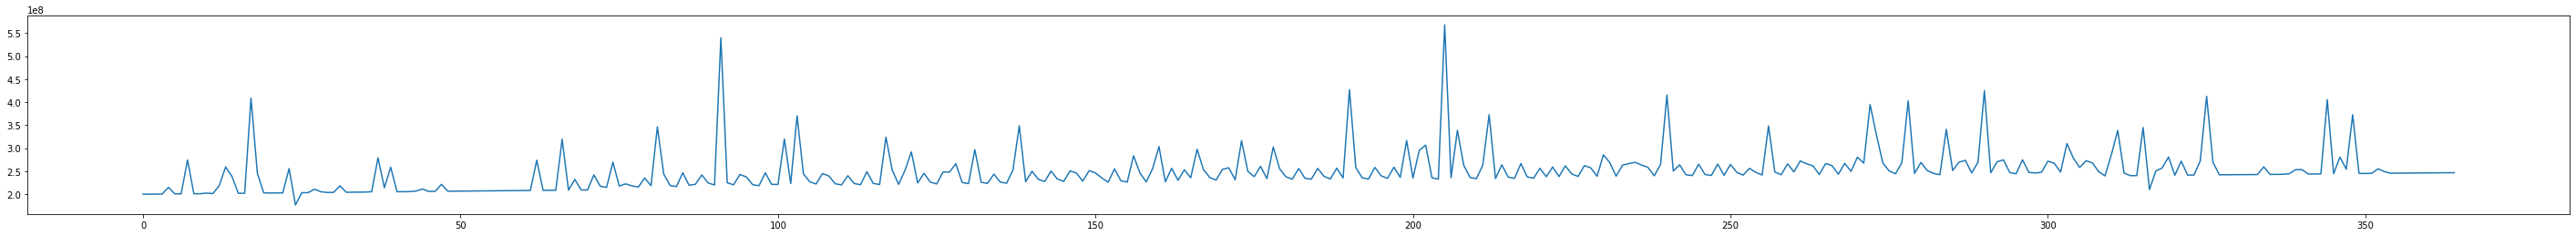

In [46]:
plt.figure(figsize=(50,4))
plt.plot(range(len(df)),df['exits']);

In [47]:
test_size = int(len(df) * 0.3) # here I ask that the test data will be 30% (0.1) of the entire data
train = df.iloc[:-test_size,:].copy() # the copy() here is important, it will prevent us from getting: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
# Try using .loc[row_index,col_indexer] = value instead
test = df.iloc[-test_size:,:].copy()
train.shape, test.shape

((256, 5), (109, 5))

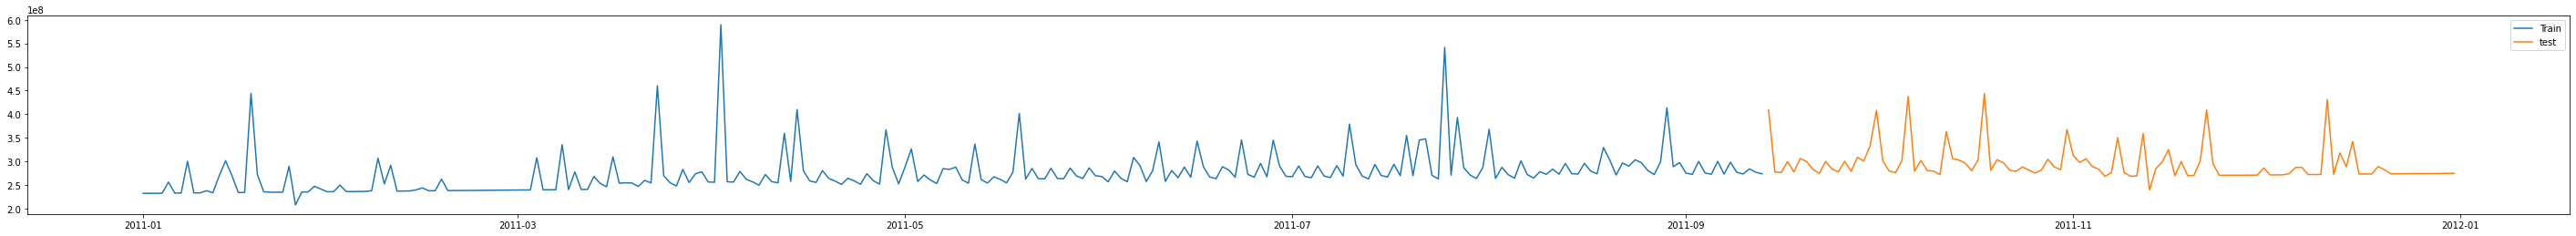

In [48]:
plt.figure(figsize=(50,4))
plt.plot(train.index,train['entries'],label='Train');
plt.plot(test.index,test['entries'],label='test')
plt.legend();

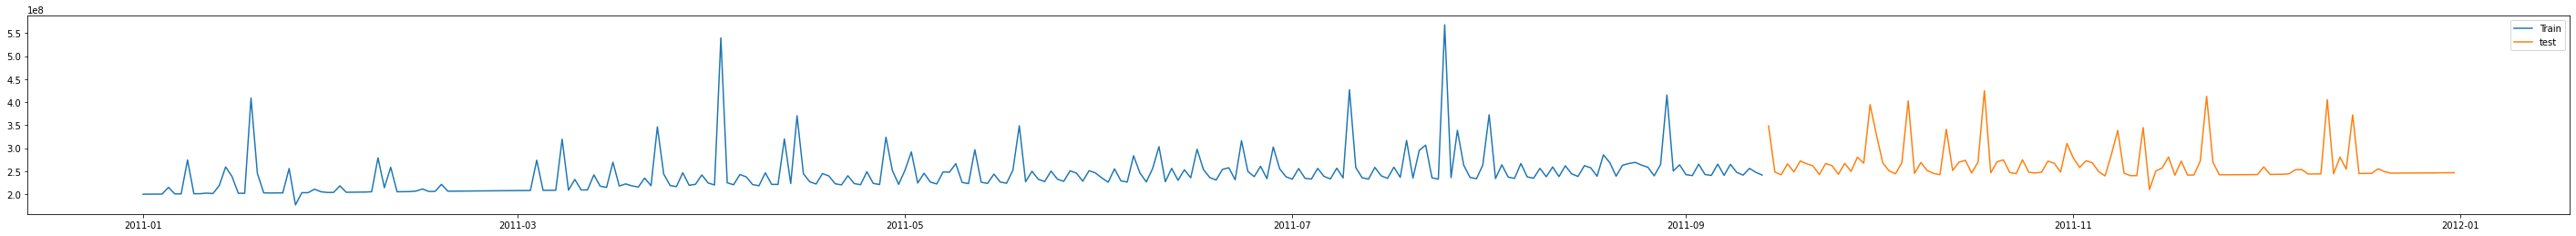

In [49]:
plt.figure(figsize=(50,4))
plt.plot(train.index,train['exits'],label='Train');
plt.plot(test.index,test['exits'],label='test')
plt.legend();

In [50]:
#seperate X and y only for the train data (for now)
X_train = train.drop(['entries','exits'],axis=1).copy()
y_train = train[['entries','exits']].copy() # the double brakets here are to keep the y in dataframe format, otherwise it will be pandas Series
print(X_train.shape, y_train.shape)

(256, 3) (256, 2)


In [51]:
X_train.head()

,flowtotal,flowdelta,flowabs
time,,,
2011-01-01,432362602.0,32720058.0,32720058.0
2011-01-02,432539508.0,32709876.0,32709876.0
2011-01-03,432713825.0,32694807.0,32694807.0
2011-01-04,432981332.0,32678916.0,32678916.0
2011-01-05,471122389.0,41586797.0,41586797.0


In [52]:
y_train.head()

,entries,exits
time,,
2011-01-01,232541330.0,199821272.0
2011-01-02,232624692.0,199914816.0
2011-01-03,232704316.0,200009509.0
2011-01-04,232830124.0,200151208.0
2011-01-05,256354593.0,214767796.0


In [53]:
# scale X and y train using sklearn MinMaxScaler model
Xscaler = MinMaxScaler(feature_range=(0, 1)) # scale so that all the data will range from 0 to 1
Xscaler.fit(X_train)
scaled_X_train = Xscaler.transform(X_train)
print(X_train.shape)
Yscaler = MinMaxScaler(feature_range=(0, 1))
Yscaler.fit(y_train)
scaled_y_train = Yscaler.transform(y_train)
print(scaled_y_train.shape)
#scaled_y_train = scaled_y_train.reshape(-1) # remove the second dimention from y so the shape changes from (n,1) to (n,)
print(scaled_y_train.shape)

# this is beutifully explain in mastery
#scaled_y_train = np.insert(scaled_y_train, 0, 0)
#scaled_y_train = np.delete(scaled_y_train, -1)

(256, 3)
(256, 2)
(256, 2)


In [54]:
X_test = test.drop(['entries','exits'],axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)

#X_test.shape
#test_generator[0][0].shape

In [55]:
n_input = 10 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = X_test.shape[0] - n_input
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

##

# O batch size deve ser igual a dimensão do X test - n_input
# pois se estamos usando n_input do passado o dados de testes devem usar o n_input para para prever o primeiro ponto

In [56]:
# check that the generator is ok, its shape should be (batch_size,n_input,n_features)
generator[0][0].shape

# It is ok if generator[0][0].shape = b_size
b_size == generator[0][0].shape[0]

True

In [57]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(n_input,n_features),return_sequences=True))
model.add(LSTM(50,activation='relu',return_sequences=True))
model.add(LSTM(10,activation='relu'))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 100)           41600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 50)            30200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                2440      
_________________________________________________________________
dense (Dense)                (None, 2)                 22        
Total params: 74,262
Trainable params: 74,262
Non-trainable params: 0
_________________________________________________________________


In [58]:
num_epochs = 50
model.fit_generator(generator,epochs=num_epochs)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
3/3 [==============================] - 3s 35ms/step - loss: 0.0409
Epoch 2/50
3/3 [==============================] - 0s 31ms/step - loss: 0.0428
Epoch 3/50
3/3 [==============================] - 0s 29ms/step - loss: 0.0361
Epoch 4/50
3/3 [==============================] - 0s 34ms/step - loss: 0.0344
Epoch 5/50
3/3 [==============================] - 0s 28ms/step - loss: 0.0293
Epoch 6/50
3/3 [==============================] - 0s 28ms/step - loss: 0.0302
Epoch 7/50
3/3 [==============================] - 0s 28ms/step - loss: 0.0233
Epoch 8/50
3/3 [==============================] - 0s 38ms/step - loss: 0.0176
Epoch 9/50
3/3 [==============================] - 0s 27ms/step - loss: 0.0153
Epoch 10/50
3/3 [==============================] - 0s 36ms/step - loss: 0.0131
Epoch 11/50
3/3 [==============================] - 0s 34ms/step - loss: 0.0118
Epoch 12/50
3/3 [==============================] - 0s 29ms/step - loss: 0.0155
Epoch 13/50
3/3 [==============================] - 0s 27ms/st

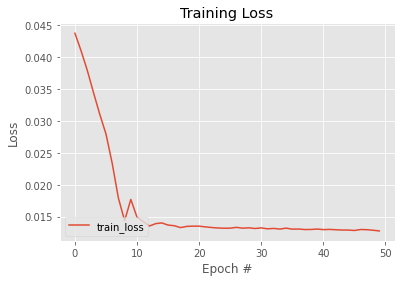

In [59]:
N = num_epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), model.history.history["loss"], label="train_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [60]:
# Make the predcitons
test_data = test_generator[0][0]
y_pred_scaled = model.predict(test_data)
y_pred = Yscaler.inverse_transform(y_pred_scaled)

In [61]:
y_pred.shape

(99, 2)

In [62]:
y_pred[:,1]

array([2.6947898e+08, 2.5111499e+08, 2.5210587e+08, 2.5257899e+08,
       2.5082246e+08, 2.5224646e+08, 2.5038478e+08, 2.4908600e+08,
       2.5332405e+08, 2.5767114e+08, 2.5919629e+08, 2.6507693e+08,
       2.6919405e+08, 2.7261261e+08, 2.8082829e+08, 2.8842077e+08,
       2.9616669e+08, 2.8469366e+08, 2.6119971e+08, 2.6073998e+08,
       2.6367302e+08, 2.6850054e+08, 2.6959638e+08, 2.5575784e+08,
       2.5742147e+08, 2.5741018e+08, 2.6058150e+08, 2.6286571e+08,
       2.6806693e+08, 2.6589381e+08, 2.6041080e+08, 2.5945410e+08,
       2.6109472e+08, 2.6285123e+08, 2.6216352e+08, 2.4992210e+08,
       2.4970434e+08, 2.4762614e+08, 2.4901750e+08, 2.5006469e+08,
       2.5145379e+08, 2.5701082e+08, 2.5876411e+08, 2.6226197e+08,
       2.6394544e+08, 2.6223542e+08, 2.6546701e+08, 2.6599733e+08,
       2.5208531e+08, 2.4877720e+08, 2.4555445e+08, 2.4268101e+08,
       2.4344648e+08, 2.4245115e+08, 2.4453920e+08, 2.5016320e+08,
       2.4866795e+08, 2.4973798e+08, 2.5163483e+08, 2.5467776e

In [63]:
print(test['exits'].values[n_input:].shape)
print(test['entries'].values[n_input:].shape)
print(y_pred[:,0].ravel().shape)
print(y_pred[:,1].ravel().shape)

(99,)
(99,)
(99,)
(99,)


In [64]:
results = pd.DataFrame({'y_true -y1 ':test['entries'].values[n_input:],'y_true - y2 ':test['exits'].values[n_input:], 'y_pred - y1':y_pred[:,0].ravel(), 'y_pred - y2':y_pred[:,1].ravel()})
results

,y_true -y1,y_true - y2,y_pred - y1,y_pred - y2
0,283889491.0,261939143.0,284592480.0,269478976.0
1,277988628.0,243235240.0,278622720.0,251114992.0
2,300613056.0,266922921.0,278901728.0,252105872.0
3,279106946.0,249496505.0,278988800.0,252578992.0
4,308886201.0,280292015.0,278333056.0,250822464.0
...,...,...,...,...
94,274513935.0,246108462.0,276184352.0,244927376.0
95,274606567.0,246224684.0,276233408.0,245186720.0
96,274714891.0,246352456.0,276376896.0,245675648.0
97,274832439.0,246487373.0,275595232.0,243743728.0


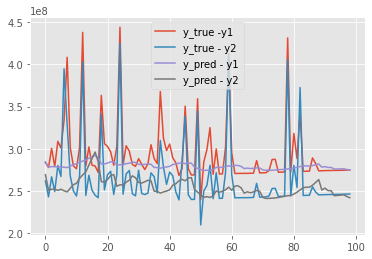

In [65]:
results.plot();

In [ ]:
# https://sailajakarra.medium.com/lstm-for-time-series-predictions-cc68cc11ce4f
# https://towardsdatascience.com/exploratory-data-analysis-eda-visualization-using-pandas-ca5a04271607

**Credits**
1. https://github.com/vincentropy/python_cartography_tutorial/blob/master/part1_basic_folium_maps.ipynb
2. https://www.kaggle.com/osunderdog/nyc-subway-data